# Quantitative Methods in Finance

Click <a href="https://colab.research.google.com/github/Lolillosky/QuantMethodsFinance/blob/main/NOTEBOOKS/2_Interest_rates_basics.ipynb">
    <img src="https://upload.wikimedia.org/wikipedia/commons/d/d0/Google_Colaboratory_SVG_Logo.svg" width="30" alt="Google Colab">
</a> to open this notebook in Google Colab.

Clone the repository

In [1]:
from IPython.display import clear_output

!rm -r {'QuantMethodsFinance'}

!git clone https://github.com/Lolillosky/QuantMethodsFinance

import sys
sys.modules.pop
sys.path.insert(0,'QuantMethodsFinance/CODE')

clear_output()

Import some libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.optimize import minimize
import pandas as pd
import re
from scipy.interpolate import CubicSpline


Modify PATH variable depending on how you run the notebook

In [3]:
# To be used if notebook is run in Google Colab
PATH = '/content/QuantMethodsFinance/'
# To be used if notebook is run in a local clone of the repository
# PATH = '../'


## Interest rate

Given the following:

| Concept | Amount |
|----------|----------|
| Initial investment    | 100     |
| Final value    | 150     |
| T-t (years)    | 5     |

Calculate simple, compounded and continuously compounded interest


In [4]:
# Your code here

## Continuously compounded interest

Check numerically that:

$$\lim_{n \to \infty}\left(1+r\frac{T-t}{n}\right)^n=\exp\left(r\left(T-t\right)\right)$$

Assume $r=0.03$ $T-t=5$

In [5]:
# Your code here


## Internal rate of return / yield of a bond

The following code is a simplified version of the pricing of a bond forgeting about dates and day count conventions.

In [6]:

from enum import Enum

class freq_options(Enum):
    QUARTERLY = 1
    SEMI_ANNUAL = 2
    ANUAL = 3


def bond_price(TTM, coupon, yield_to_mat, freq):

    if freq == freq_options.QUARTERLY:
          delta = 0.25
    elif freq == freq_options.SEMI_ANNUAL:
        delta = 0.5
    elif freq == freq_options.ANUAL:
        delta = 1
    else:
        raise ValueError("Invalid frequency")

    payment_times = np.arange(TTM,0, step=-delta)[::-1]

    return np.sum(coupon * delta * (1.0 + yield_to_mat)**(-payment_times)) + (1.0 + yield_to_mat)**(-TTM)


In [7]:
bond_price(5,0.03,0.05,freq_options.ANUAL)

0.9134104665873835

For a 5 year maturity bond, with annual coupons of $3\%$, plot the dirty price as a function of its yield. If the yield of a bond rises, does the bond holder gain or loose money?

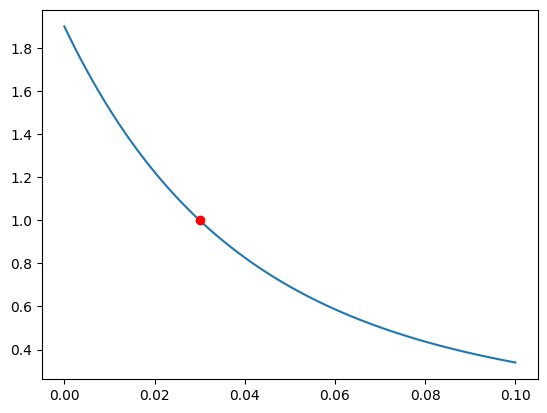

In [8]:
# Your code here

maturity = 30
coupon = 0.03
ytm = np.linspace(0,0.1,100)

price = [bond_price(maturity, coupon, x, freq_options.ANUAL) for x in ytm]


plt.plot(ytm, price)
plt.plot(0.03, 1.0, 'o', color = 'red')

For yields equal to $1\%,\ 3\%,\ 5\%$, plot the dirty price as time goes by and we approach the maturity of the bond.

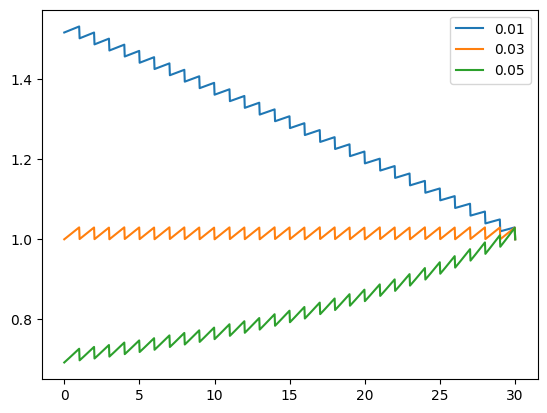

In [9]:
# Your code here

maturity = np.linspace(0,30,1000)
coupon = 0.03
y1 = 0.01
y2 = 0.03
y3 = 0.05


price1 = [bond_price(m, coupon, y1, freq_options.ANUAL) for m in maturity]
price2 = [bond_price(m, coupon, y2, freq_options.ANUAL) for m in maturity]
price3 = [bond_price(m, coupon, y3, freq_options.ANUAL) for m in maturity]


plt.plot(maturity[::-1], price1, label= '0.01')
plt.plot(maturity[::-1], price2, label= '0.03')
plt.plot(maturity[::-1], price3, label= '0.05')

plt.legend()




If the price of the bond is $103\%$, compute its yield. Use fsolve function of Scipy.

In [10]:
# Your code here

fsolve(lambda y: bond_price(5,0.03,y,freq_options.ANUAL)-1.03, 0.03)

array([0.02356917])

In [11]:
(lambda x: x+1)(7)



8

## Duration

Code a function to compute the duration of a bond for a given maturity, coupon, yield and payment frequency.

In [12]:
def bond_duration(TTM, coupon, yield_to_mat, freq, charts = False):

    if freq == freq_options.QUARTERLY:
          delta = 0.25
    elif freq == freq_options.SEMI_ANNUAL:
        delta = 0.5
    elif freq == freq_options.ANUAL:
        delta = 1
    else:
        raise ValueError("Invalid frequency")

    payment_times = np.arange(TTM,0, step=-delta)[::-1]

    disc_cf = coupon * delta * (1+yield_to_mat)**(-payment_times)

    disc_cf[-1] += (1+yield_to_mat)**(-payment_times[-1])

    disc_cf_times_t = disc_cf * payment_times

    duration = np.sum(disc_cf_times_t) / np.sum(disc_cf)

    if charts:
      plt.bar(payment_times, disc_cf)
      plt.vlines(duration, 0, 1, color = 'red')
      plt.show()

    return duration



    # your code here

For a 30 year bond with a coupon of $3\%$, plot the bond duration as time evolves for yields of $1\%,\ 3\%,\ 5\%$.

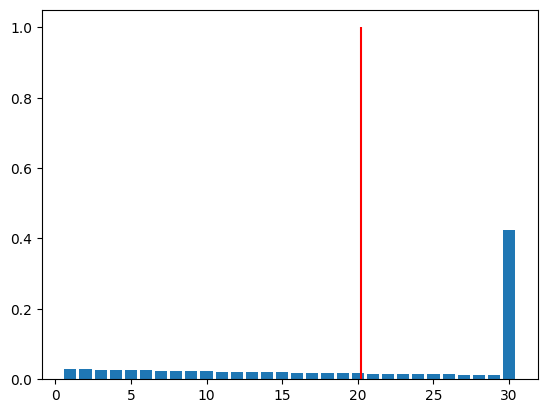

20.188454589953867

In [13]:
bond_duration(30,0.03,0.03,freq_options.ANUAL, True)

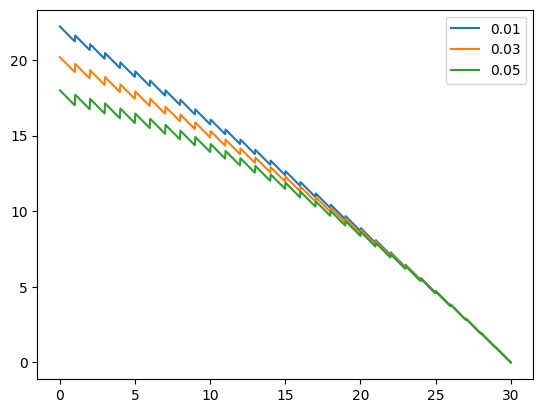

In [14]:
maturity = np.linspace(0.0001,30,1000)
coupon = 0.03
y1 = 0.01
y2 = 0.03
y3 = 0.05


duration1 = [bond_duration(m, coupon, y1, freq_options.ANUAL) for m in maturity]
duration2 = [bond_duration(m, coupon, y2, freq_options.ANUAL) for m in maturity]
duration3 = [bond_duration(m, coupon, y3, freq_options.ANUAL) for m in maturity]


plt.plot(maturity[::-1], duration1, label= '0.01')
plt.plot(maturity[::-1], duration2, label= '0.03')
plt.plot(maturity[::-1], duration3, label= '0.05')

plt.legend()



In [15]:
# Your code here

Same for a zero coupon bond (bond with coupon equal to $0\%$).

In [16]:
# Your code here

Can you provide a physical interpretation of duration?

## Bootstrapping the yield curve

Let us read the historical data included in the spgb_hist.csv file.

In [17]:
spgb_hist = pd.read_csv(PATH + 'DATA/spgb_hist.csv', parse_dates=True, index_col=0, dayfirst=True)

spgb_hist.head()

,SPGB 0 1/31/2025 Govt,SPGB 1.6 4/30/2025 Govt,SPGB 0 5/31/2025 Govt,SPGB 4.65 7/30/2025 Govt,SPGB 2.15 10/31/2025 Govt,SPGB 0 1/31/2026 Govt,SPGB 1.95 4/30/2026 Govt,SPGB 2.8 5/31/2026 Govt,SPGB 5.9 7/30/2026 Govt,SPGB 1.3 10/31/2026 Govt,...,SPGB 3.45 7/30/2043 Govt,SPGB 5.15 10/31/2044 Govt,SPGB 2.9 10/31/2046 Govt,SPGB 2.7 10/31/2048 Govt,SPGB 1 10/31/2050 Govt,SPGB 1.9 10/31/2052 Govt,SPGB 4 10/31/2054 Govt,SPGB 4 10/31/2064 Govt,SPGB 3.45 7/30/2066 Govt,SPGB 1.45 10/31/2071 Govt
Dates,,,,,,,,,,,,,,,,,,,,,
2023-10-02,3.672,3.594,3.591,3.541,3.472,3.506,3.484,3.517,3.512,3.477,...,4.488,4.452,4.480,4.511,4.490,4.584,NaN,4.321,4.628,4.519
2023-10-03,3.670,3.587,3.597,3.547,3.476,3.511,3.490,3.525,3.525,3.492,...,4.591,4.555,4.582,4.617,4.601,4.691,NaN,4.555,4.734,4.623
2023-10-04,3.641,3.554,3.552,3.503,3.437,3.472,3.451,3.492,3.484,3.459,...,4.519,4.482,4.509,4.538,4.519,4.610,NaN,4.555,4.655,4.547
2023-10-05,3.635,3.545,3.537,3.490,3.420,3.453,3.432,3.473,3.463,3.433,...,4.524,4.489,4.518,4.549,4.539,4.629,NaN,4.555,4.672,4.569
2023-10-06,3.645,3.544,3.532,3.482,3.412,3.443,3.423,3.466,3.456,3.433,...,4.523,4.489,4.516,4.546,4.531,4.623,NaN,4.555,4.676,4.572


The following code extracts the maturity and coupon of every bond. We will bootstrap the curve on the last date of the dataframe.

In [18]:

# Calibration date will be last date of the dataframe.
calibration_date = spgb_hist.index[-1]

# Regular expression pattern to extract dates in the format mm/dd/yyyy.
date_pattern =  r"\b\d*\.?\d{0,2}\s(\d{1,2}/\d{1,2}/\d{4})\b"

maturity_dates = [re.search(date_pattern, item).group(1) for item in spgb_hist.columns if re.search(date_pattern, item)]

maturity_dates = pd.to_datetime(maturity_dates, format='%m/%d/%Y');

# Regular expression pattern to extract coupons in the format d.dd.
coupon_pattern = r"\b\d+(\.\d{1,2})?\b"

coupons = np.float64([re.search(coupon_pattern, item).group() for item in spgb_hist.columns if re.search(coupon_pattern, item)])/100

# Year fraction to maturity of each bond.
years_to_maturity = (maturity_dates - calibration_date).days / 365

# Let us print coupons and years to maturity.
print(coupons)
print(years_to_maturity)



[0.     0.016  0.     0.0465 0.0215 0.     0.0195 0.028  0.059  0.013
 0.     0.015  0.025  0.008  0.0145 0.     0.014  0.014  0.0515 0.06
 0.0145 0.035  0.008  0.006  0.027  0.005  0.0195 0.0125 0.001  0.031
 0.005  0.007  0.0575 0.0255 0.0315 0.0235 0.0355 0.0325 0.0345 0.0185
 0.042  0.0085 0.039  0.049  0.012  0.047  0.01   0.0345 0.0515 0.029
 0.027  0.01   0.019  0.04   0.04   0.0345 0.0145]
Index([0.23013698630136986,   0.473972602739726,  0.5589041095890411,
        0.7232876712328767,  0.9780821917808219,  1.2301369863013698,
         1.473972602739726,   1.558904109589041,  1.7232876712328766,
         1.978082191780822,    2.23013698630137,   2.473972602739726,
         2.558904109589041,   2.723287671232877,   2.978082191780822,
          3.23013698630137,  3.4767123287671233,  3.7260273972602738,
        3.9808219178082194,   4.232876712328767,   4.476712328767123,
         4.561643835616438,   4.726027397260274,   4.980821917808219,
         5.232876712328767,   5.4767123

The following function calculates the yield of a bond from its coupon, maturity and price.

In [19]:
def bond_yield(TTM, coupon, price, freq):

    return fsolve(lambda x: bond_price(TTM, coupon, x, freq) - price, coupon,xtol=1e-8)[0]

Let us check that the function works.

In [20]:
coupon = 0.05
price = 1.00
maturity = 30

bond_yield(maturity, coupon, price, freq_options.ANUAL)

0.05

The following class is the IR curve class. It wrapps a cubic spline interpolator and assumes cubic spline interpolation in zero copupon rates in rates * time (an ussual assumption).

In [21]:
class IR_Curve:

    def __init__(self, time_pillars, rates):
        # Append zero at the beginning for both time_pillars and rates
        time_pillars = np.concatenate(([0], time_pillars))
        rates = np.concatenate(([0], rates))
        time_times_rate = rates * time_pillars

        # Natural cubic spline interpolation
        self.interpolator = CubicSpline(time_pillars, time_times_rate, bc_type='natural')

    def zero_coupon_rates(self, time_pillars):
        # Check for negative maturities and raise an error if found
        if np.any(time_pillars < 0):
            raise ValueError("Maturity cannot be negative.")

        # Calculate the true limit for zero-coupon rate as t approaches 0
        zero_coupon_rates = np.zeros_like(time_pillars, dtype=float)
        non_zero_mask = time_pillars != 0

        # Calculate rates for non-zero times
        zero_coupon_rates[non_zero_mask] = self.interpolator(time_pillars[non_zero_mask]) / time_pillars[non_zero_mask]

        # Use the derivative at t = 0 as the limit for the zero-coupon rate at t = 0
        zero_coupon_rates[~non_zero_mask] = self.interpolator.derivative()(0)

        return zero_coupon_rates

    def discount_factors(self, time_pillars):
        # Check for negative maturities and raise an error if found
        if np.any(time_pillars < 0):
            raise ValueError("Maturity cannot be negative.")

        # Evaluate the spline and compute discount factors
        return np.exp(-self.interpolator(time_pillars))



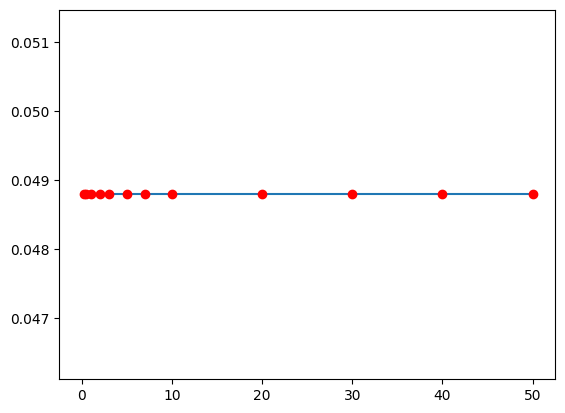

In [22]:
pillars = np.array([0.25, 0.5, 1, 2, 3, 5, 7, 10, 20, 30, 40, 50])
rates = np.array([0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055, 0.06, 0.06])
rates = np.ones_like(pillars) * (np.log(1.05))
ir_curve = IR_Curve(pillars, rates)

time_pillars = np.linspace(0.0, 50, 100)


plt.plot(time_pillars, ir_curve.zero_coupon_rates(time_pillars))
plt.plot(pillars, rates, 'o', color='red')


Taking into consideration the curve object, modify the bond price function so that it prices bonds discounting its cashflows with the curve.

In [23]:
def bond_price_curve(TTM, coupon, curve, freq):

    if freq == freq_options.QUARTERLY:
          delta = 0.25
    elif freq == freq_options.SEMI_ANNUAL:
        delta = 0.5
    elif freq == freq_options.ANUAL:
        delta = 1
    else:
        raise ValueError("Invalid frequency")

    payment_times = np.arange(TTM,0, step=-delta)[::-1]

    # your code here
    discount_factors = curve.discount_factors(payment_times)

    bond_price = np.sum(discount_factors * delta * coupon)

    bond_price += discount_factors[-1]

    return bond_price

In [24]:
bond_price_curve(5, 0.05, ir_curve, freq_options.ANUAL)

0.9999999999999998

Write a function that computes the yield of a bond if the cashflows are discounted with the curve.

In [25]:
def bond_yield_curve(TTM, coupon, curve, freq):

    # your code
    model_price = bond_price_curve(TTM, coupon, curve, freq)

    return bond_yield(TTM,coupon,model_price,freq)

In [26]:
bond_yield_curve(5,0.05,ir_curve,freq_options.ANUAL)

0.05

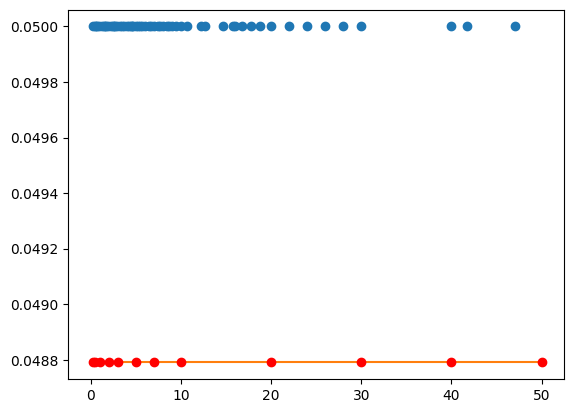

In [27]:
yields_test = [bond_yield_curve(m,c,ir_curve,freq_options.ANUAL) for m, c in zip(years_to_maturity,coupons) ]

plt.plot(years_to_maturity,yields_test, 'o')

plt.plot(time_pillars, ir_curve.zero_coupon_rates(time_pillars))
plt.plot(pillars, rates, 'o', color='red')


Complete the class below so that it calibrates th zero coupon curve from bond yields

In [28]:
class yield_curve_bootsrap:

    def __init__(self, bond_maturities, bond_yields, bond_coupons, curve_pillars, init_guess=0.05):

        self.bond_maturities = bond_maturities
        self.bond_yields = bond_yields
        self.curve_pillars = curve_pillars
        self.bond_coupons = np.array(bond_coupons)
        self.init_guess = init_guess*np.ones_like(curve_pillars)

    def compute_model_yields(self, curve_rates):

        # your code here

        curve = IR_Curve(self.curve_pillars, curve_rates)

        return np.array([bond_yield_curve(m,c,curve ,
            freq_options.ANUAL) for m, c in zip(self.bond_maturities,self.bond_coupons) ])

    def compute_yield_mse(self, curve_rates):

        model_yields = self.compute_model_yields(curve_rates)

        return np.mean((model_yields - self.bond_yields)**2)

    def bootstrap(self):

        pillar_rates = minimize(self.compute_yield_mse, self.init_guess)['x']

        return {'pillar rates': pillar_rates, 'curve object': IR_Curve(self.curve_pillars, pillar_rates)}



In [29]:
boot = yield_curve_bootsrap(years_to_maturity,spgb_hist.iloc[-1]/100, coupons,pillars)



In [30]:
boot_output = boot.bootstrap()

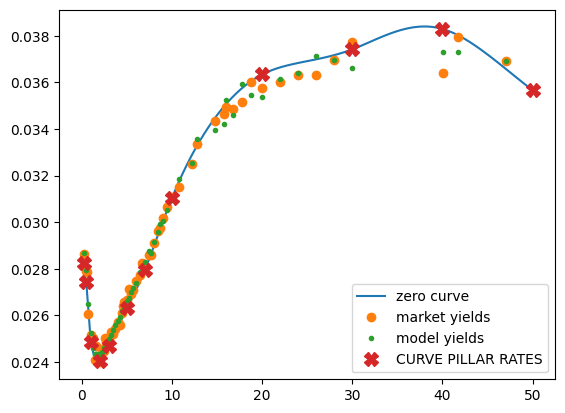

In [31]:
plt.plot(time_pillars, boot_output['curve object'].zero_coupon_rates(time_pillars), label = 'zero curve')
plt.plot(boot.bond_maturities, boot.bond_yields, 'o', label = 'market yields')
plt.plot(boot.bond_maturities, boot.compute_model_yields(boot_output['pillar rates']), 'o', label = 'model yields', markersize = 3)
plt.plot(boot.curve_pillars, boot_output['pillar rates'], 'X', label = 'CURVE PILLAR RATES', markersize = 10)


plt.legend()


Plot 1 yr spanning forward rates

In [50]:
# your code here


Plot the instantaneous forward curve

In [51]:
# your code here

## Bootstrapping the OIS curve

Read the historical data.

In [53]:
swaps_hist = pd.read_csv(PATH + 'DATA/Swaps_Hist.csv', parse_dates=True, index_col=0, dayfirst=True, sep = ';')

swaps_hist.head()

,ESTER 1Y,ESTER 2Y,ESTER 3Y,ESTER 4Y,ESTER 5Y,ESTER 6Y,ESTER 7Y,ESTER 8Y,ESTER 9Y,ESTER 10Y,...,EURIBOR 6M 9Y,EURIBOR 6M 10Y,EURIBOR 6M 11Y,EURIBOR 6M 12Y,EURIBOR 6M 15Y,EURIBOR 6M 20Y,EURIBOR 6M 25Y,EURIBOR 6M 30Y,EURIBOR 6M 40Y,EURIBOR 6M 50Y
Dates,,,,,,,,,,,,,,,,,,,,,
2023-01-03,3.0839,3.0764,2.9306,2.8185,2.7630,2.7259,2.7041,2.6992,2.7082,2.7236,...,2.9908,2.9933,2.9990,2.9966,2.9479,2.7369,2.5124,2.3398,2.0652,1.8645
2023-01-04,3.0292,2.9912,2.8365,2.7392,2.6772,2.6350,2.6167,2.6196,2.6398,2.6586,...,2.8913,2.9003,2.9090,2.9135,2.8802,2.7005,2.4859,2.3074,2.0385,1.8352
2023-01-05,3.0790,3.0414,2.8896,2.7967,2.7296,2.6920,2.6689,2.6632,2.6772,2.6875,...,2.9324,2.9408,2.9481,2.9543,2.9172,2.7363,2.5230,2.3505,2.0636,1.8619
2023-01-06,3.0445,2.9962,2.8493,2.7240,2.6470,2.6016,2.5786,2.5768,2.5844,2.5953,...,2.8466,2.8534,2.8608,2.8636,2.8300,2.6506,2.4441,2.2712,1.9918,1.7901
2023-01-09,3.0757,3.0159,2.8431,2.7362,2.6763,2.6302,2.6072,2.6022,2.6112,2.6262,...,2.8585,2.8668,2.8744,2.8765,2.8456,2.6831,2.4637,2.2946,2.0204,1.8045


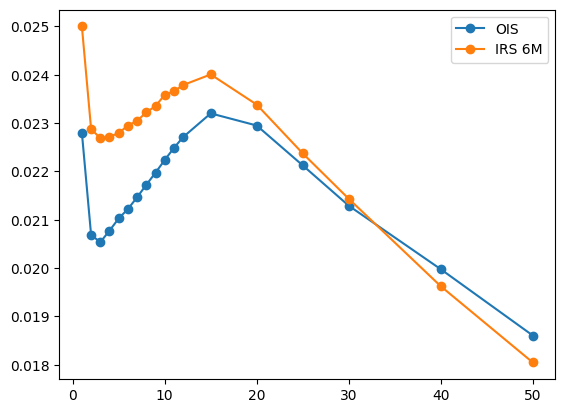

In [74]:
quotes = swaps_hist.loc['11-08-2024']


regex =  r".*?(\d{1,2})Y$"

# Extract ois quotes
ois_quotes = np.array([[int(re.search(regex, s).group(1)), v/100]  for s, v in zip(swaps_hist.columns, quotes.values) if (re.search(regex, s) and 'ESTER' in s)])

# Extract irs quotes
irs_quotes = np.array([[int(re.search(regex, s).group(1)), v/100]  for s, v in zip(swaps_hist.columns, quotes.values) if (re.search(regex, s) and 'EURIBOR' in s)])

plt.plot(ois_quotes[:,0], ois_quotes[:,1], 'o-', label = 'OIS')
plt.plot(irs_quotes[:,0], irs_quotes[:,1], 'o-', label = 'IRS 6M')

plt.legend()


In [60]:
#

array([2.2799, 2.0688, 2.0536, 2.0775, 2.1028, 2.1222, 2.1466, 2.1724,
       2.1974, 2.2236, 2.2486, 2.271 , 2.3201, 2.295 , 2.2125, 2.1291,
       1.9977, 1.8606, 2.4999, 2.288 , 2.2686, 2.2716, 2.2795, 2.2949,
       2.3046, 2.3224, 2.3351, 2.3585, 2.3657, 2.3787, 2.4007, 2.3382,
       2.2373, 2.1434, 1.9625, 1.8048])